### Visualizing weather data

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

#import findspark
#findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from spark_PCA import computeCov

In [3]:

from computeStatistics import computeOverAllDist, STAT_Descriptions

### Read weather data for state

In [4]:
state='NY'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

%mkdir -p data_dir
!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > ../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  4998k      0  0:00:12  0:00:12 --:--:-- 9903k
-rw-rw-r-- 1 nick nick 64M Nov 30 23:42 ../Data/Weather/NY.tgz


In [5]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir


weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
print(weather_df.count())
weather_df.show(5)

/home/nick/git/analytics_with_spark/02-pca_and_weather_analysis/Data/Weather
77828	./NY.parquet
/home/nick/git/analytics_with_spark/02-pca_and_weather_analysis/Section2-Weather-PCA_PART2
168398
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.5708

### read statistics information for state.

In [6]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > ../Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0  5610k      0  0:00:05  0:00:05 --:--:-- 7638k


In [7]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath
!gunzip -f $gzpath
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))
print('keys from STAT=',STAT.keys())

../Data/Weather/STAT_NY.pickle.gz
-rw-rw-r-- 1 nick nick 31373293 Nov 30 23:42 ../Data/Weather/STAT_NY.pickle.gz
keys from STAT= dict_keys(['TMAX_s20', 'TOBS_s20', 'TMIN_s20', 'SNWD', 'SNOW_s20', 'PRCP', 'SNOW', 'TOBS', 'SNWD_s20', 'TMAX', 'TMIN', 'PRCP_s20'])


### Read information about US weather stations.

In [8]:
filename='US_stations.tsv.gz'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/Info/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command
filename_no_gz = filename[:-3]
!gunzip -f $data_dir/$filename
!ls -lh $data_dir/US_stations*

curl https://mas-dse-open.s3.amazonaws.com/Weather/Info/US_stations.tsv.gz > ../Data/Weather/US_stations.tsv.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  320k  100  320k    0     0   301k      0  0:00:01  0:00:01 --:--:--  301k
-rw-rw-r-- 1 nick nick 715K Nov 30 23:42 ../Data/Weather/US_stations.tsv


In [9]:
#read csv into pandas dataframe
PATH='%s/%s'%(data_dir,filename_no_gz)
print(PATH)
stations=pd.read_csv(PATH,sep='\t')

../Data/Weather/US_stations.tsv


In [24]:
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, FloatType,BinaryType

schema = StructType([StructField("Station", StringType(), False),
                     StructField("Dist_coast", FloatType(), False),
                     StructField("Latitude", FloatType(), False),
                     StructField("Longitude", FloatType(), False),
                     StructField("Elevation", FloatType(), False),
                     StructField("State", StringType(), True),                  
                     StructField("Station_Name", StringType(), False)])                


In [25]:
stations_df = sqlContext.createDataFrame(stations,schema).drop('State')
stations_df.show(4)

+-----------+----------+--------+---------+---------+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|    Station_Name|
+-----------+----------+--------+---------+---------+----------------+
|USC00044534|   107.655| 36.0042|  -119.96|     73.2|  KETTLEMAN CITY|
|USC00356784|   0.61097| 42.7519|-124.5011|     12.8|PORT ORFORD NO 2|
|USC00243581|   1316.54| 47.1064|-104.7183|    632.8|        GLENDIVE|
|USC00205601|   685.501|   41.75| -84.2167|    247.2|         MORENCI|
+-----------+----------+--------+---------+---------+----------------+
only showing top 4 rows



In [26]:
jdf=weather_df.join(stations_df,on='Station',how='left')
jdf.show(4)

+-----------+-----------+----+--------------------+-----------------+------------------+------------------+-----------------+-----+-------+----------+--------+---------+---------+------------+
|    Station|Measurement|Year|              Values|       dist_coast|          latitude|         longitude|        elevation|state|   name|Dist_coast|Latitude|Longitude|Elevation|Station_Name|
+-----------+-----------+----+--------------------+-----------------+------------------+------------------+-----------------+-----+-------+----------+--------+---------+---------+------------+
|USC00303955|   SNOW_s20|1992|[00 00 00 00 00 0...|362.2770080566406|42.791900634765625|-77.51360321044922|243.8000030517578|   NY|HONEOYE|   362.277| 42.7919| -77.5136|    243.8|     HONEOYE|
|USC00303955|   SNOW_s20|1993|[1C 49 1E 49 25 4...|362.2770080566406|42.791900634765625|-77.51360321044922|243.8000030517578|   NY|HONEOYE|   362.277| 42.7919| -77.5136|    243.8|     HONEOYE|
|USC00303955|   SNOW_s20|1994|[2B 4

In [27]:
jdf.select(['Station','Measurement','Year','Station_Name']).show(4)

+-----------+-----------+----+------------+
|    Station|Measurement|Year|Station_Name|
+-----------+-----------+----+------------+
|USC00303955|   SNOW_s20|1992|     HONEOYE|
|USC00303955|   SNOW_s20|1993|     HONEOYE|
|USC00303955|   SNOW_s20|1994|     HONEOYE|
|USC00303955|   SNOW_s20|1995|     HONEOYE|
+-----------+-----------+----+------------+
only showing top 4 rows



In [28]:
jdf.count()

168398

In [29]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

In [30]:
# get all measurements for a particular year and a particular station
measurement='PRCP'
Query="""
SELECT *
FROM jdf 
WHERE Measurement='%s'
AND Station_Name='BUFFALO'
ORDER BY YEAR"""%(measurement)
df=sqlContext.sql(Query)
print(df.count())
df.show(3)

150
+-----------+-----------+----+--------------------+------------------+--------------+---------------+------------------+-----+-------+----------+--------+---------+---------+------------+
|    Station|Measurement|Year|              Values|        dist_coast|      latitude|      longitude|         elevation|state|   name|Dist_coast|Latitude|Longitude|Elevation|Station_Name|
+-----------+-----------+----+--------------------+------------------+--------------+---------------+------------------+-----+-------+----------+--------+---------+---------+------------+
|USC00301010|       PRCP|1871|[00 42 00 00 00 4...|437.75201416015625|42.88330078125|-78.88330078125|-999.9000244140625|   NY|BUFFALO|   437.752| 42.8833| -78.8833|   -999.9|     BUFFALO|
|USC00301010|       PRCP|1872|[40 4E 00 00 60 5...|437.75201416015625|42.88330078125|-78.88330078125|-999.9000244140625|   NY|BUFFALO|   437.752| 42.8833| -78.8833|   -999.9|     BUFFALO|
|USC00301010|       PRCP|1873|[00 00 40 4E 00 4...|437.7

In [31]:
df.select(['Station','Year','Values']).schema

StructType(List(StructField(Station,StringType,true),StructField(Year,LongType,true),StructField(Values,BinaryType,true)))

### Smoothing by convolving with gaussian window

In [33]:
from astropy.convolution import convolve
from scipy import signal
#using astrophy.convolution.convolve and not scipy.signal.convolve because the first can handle nans.

orig_pdf=df.toPandas()
orig_pdf.head()

def Smoother(orig_pdf,order=101,std=20):
    window = signal.gaussian(order, std=std)
    window/=sum(window)

    L=list(orig_pdf['Values'])

    orig=np.stack([unpackArray(V,np.float16) for V in L])
    orig_shape=orig.shape
    orig=orig.flatten()

    smoothed = convolve(orig, window)
    smoothed=np.reshape(smoothed,orig_shape)

    #create a new pandas dataframe
    smoothed_pdf=orig_pdf.copy()   # make a copy

    L=[packArray(smoothed[i,:]) for i in range(smoothed.shape[0])]
    smoothed_pdf['Values']=L

    smoothed_pdf.loc[0,'Measurement']

    new_name = 'smooth_'+smoothed_pdf.loc[0,'Measurement']
    smoothed_pdf['Measurement']=new_name
    return smoothed_pdf

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [34]:
smoothed_pdf=Smoother(orig_pdf)
smoothed_pdf.head(3)

,Station,Measurement,Year,Values,dist_coast,latitude,longitude,elevation,state,name,Dist_coast,Latitude,Longitude,Elevation,Station_Name
0,USC00301010,smooth_PRCP,1871,"[150, 68, 209, 68, 13, 69, 73, 69, 135, 69, 19...",437.752014,42.883301,-78.883301,-999.900024,NY,BUFFALO,437.752014,42.883301,-78.883301,-999.900024,BUFFALO
1,USC00301010,smooth_PRCP,1872,"[199, 76, 201, 76, 204, 76, 183, 76, 182, 76, ...",437.752014,42.883301,-78.883301,-999.900024,NY,BUFFALO,437.752014,42.883301,-78.883301,-999.900024,BUFFALO
2,USC00301010,smooth_PRCP,1873,"[222, 75, 207, 75, 194, 75, 180, 75, 150, 75, ...",437.752014,42.883301,-78.883301,-999.900024,NY,BUFFALO,437.752014,42.883301,-78.883301,-999.900024,BUFFALO


In [35]:
Query="""
SELECT Station,count(Year) as count
FROM jdf 
WHERE Measurement='%s'
GROUP BY Station
ORDER BY count
"""%(measurement)
stat_pdf=sqlContext.sql(Query).toPandas()
stat_pdf.tail(4)

,Station,count
339,USC00306774,121
340,USC00304912,123
341,USC00307633,125
342,USW00094728,138


In [36]:
stations=list(stat_pdf['Station'])
stations=stations[-1:0:-1]
stations[:4]

['USW00094728', 'USC00307633', 'USC00304912', 'USC00306774']

In [38]:
import pyspark.sql.functions as sqlf
import pyspark
import pyarrow
pyspark.__version__

'2.3.1'

In [39]:
ndf=Smoother(orig_pdf)
ndf.head(3)

,Station,Measurement,Year,Values,dist_coast,latitude,longitude,elevation,state,name,Dist_coast,Latitude,Longitude,Elevation,Station_Name
0,USC00301010,smooth_PRCP,1871,"[150, 68, 209, 68, 13, 69, 73, 69, 135, 69, 19...",437.752014,42.883301,-78.883301,-999.900024,NY,BUFFALO,437.752014,42.883301,-78.883301,-999.900024,BUFFALO
1,USC00301010,smooth_PRCP,1872,"[199, 76, 201, 76, 204, 76, 183, 76, 182, 76, ...",437.752014,42.883301,-78.883301,-999.900024,NY,BUFFALO,437.752014,42.883301,-78.883301,-999.900024,BUFFALO
2,USC00301010,smooth_PRCP,1873,"[222, 75, 207, 75, 194, 75, 180, 75, 150, 75, ...",437.752014,42.883301,-78.883301,-999.900024,NY,BUFFALO,437.752014,42.883301,-78.883301,-999.900024,BUFFALO


In [40]:
from time import time
# get all measurements for a particular year and a particular station
measurement='PRCP'
Query_template="""
SELECT *
FROM jdf 
WHERE Measurement='%s'
AND Station='%s'
ORDER BY YEAR"""

for station in stations:
    t0=time()
    Query=Query_template%(measurement,station)

    pdf=sqlContext.sql(Query).toPandas()
    t1=time()
    smoothed_pdf=Smoother(pdf)
    t2=time()
    smoothed_df= sqlContext.createDataFrame(smoothed_pdf)
    jdf=jdf.union(smoothed_df)
    t3=time()
    print('Station=%s, rows=%d, prep=%5.2f,compute=%5.2f,cleanup=%f5.2,total=%f5.2'
          %(station,pdf.shape[0],t1-t0,t2-t1,t3-t2,t3-t0))

Station=USW00094728, rows=138, prep= 2.97,compute= 0.04,cleanup=0.7571605.2,total=3.7617215.2
Station=USC00307633, rows=125, prep= 2.16,compute= 0.02,cleanup=0.0279115.2,total=2.2108955.2
Station=USC00304912, rows=123, prep= 1.84,compute= 0.03,cleanup=0.0460985.2,total=1.9115095.2
Station=USC00306774, rows=121, prep= 1.71,compute= 0.02,cleanup=0.0285075.2,total=1.7595045.2
Station=USC00304174, rows=121, prep= 1.51,compute= 0.02,cleanup=0.0292615.2,total=1.5548735.2
Station=USC00301752, rows=121, prep= 1.64,compute= 0.02,cleanup=0.0299655.2,total=1.6890575.2
Station=USC00302610, rows=121, prep= 1.69,compute= 0.02,cleanup=0.0268645.2,total=1.7365575.2
Station=USC00306164, rows=121, prep= 1.46,compute= 0.02,cleanup=0.0259125.2,total=1.5073795.2
Station=USC00309000, rows=120, prep= 1.43,compute= 0.02,cleanup=0.0306955.2,total=1.4844845.2
Station=USC00300183, rows=120, prep= 1.45,compute= 0.02,cleanup=0.0275005.2,total=1.5004775.2
Station=USC00309292, rows=118, prep= 1.37,compute= 0.02,clea

Station=USC00301152, rows=72, prep= 1.21,compute= 0.01,cleanup=0.0266475.2,total=1.2516645.2
Station=USC00303889, rows=72, prep= 1.18,compute= 0.01,cleanup=0.0280945.2,total=1.2229395.2
Station=USC00300766, rows=71, prep= 1.16,compute= 0.01,cleanup=0.0324805.2,total=1.2007485.2
Station=USC00306623, rows=70, prep= 2.20,compute= 0.01,cleanup=0.0335165.2,total=2.2478975.2
Station=USW00014750, rows=70, prep= 1.23,compute= 0.01,cleanup=0.0281055.2,total=1.2734275.2
Station=USW00014732, rows=70, prep= 1.17,compute= 0.01,cleanup=0.0316195.2,total=1.2134705.2
Station=USC00302574, rows=70, prep= 1.19,compute= 0.01,cleanup=0.0272875.2,total=1.2255385.2
Station=USC00303284, rows=70, prep= 1.27,compute= 0.01,cleanup=0.0263875.2,total=1.3071865.2
Station=USC00302129, rows=68, prep= 1.15,compute= 0.01,cleanup=0.0256285.2,total=1.1865095.2
Station=USW00094745, rows=68, prep= 1.36,compute= 0.01,cleanup=0.0378135.2,total=1.4097705.2
Station=USC00300047, rows=68, prep= 1.33,compute= 0.01,cleanup=0.02527

Station=USC00304715, rows=38, prep= 1.32,compute= 0.01,cleanup=0.0285955.2,total=1.3601615.2
Station=USC00305711, rows=38, prep= 2.42,compute= 0.01,cleanup=0.0305065.2,total=2.4539845.2
Station=USC00308902, rows=38, prep= 1.16,compute= 0.01,cleanup=0.0292465.2,total=1.1934285.2
Station=USC00308746, rows=37, prep= 1.12,compute= 0.01,cleanup=0.0275565.2,total=1.1605295.2
Station=USC00308152, rows=37, prep= 1.12,compute= 0.01,cleanup=0.0288445.2,total=1.1568745.2
Station=USC00308080, rows=37, prep= 1.11,compute= 0.01,cleanup=0.0290915.2,total=1.1426035.2
Station=USC00308946, rows=36, prep= 1.11,compute= 0.01,cleanup=0.0310215.2,total=1.1463205.2
Station=USC00306957, rows=36, prep= 2.27,compute= 0.01,cleanup=0.0309035.2,total=2.3089625.2
Station=USC00306356, rows=35, prep= 1.12,compute= 0.01,cleanup=0.0278665.2,total=1.1598725.2
Station=USC00301095, rows=35, prep= 1.11,compute= 0.01,cleanup=0.0287125.2,total=1.1477185.2
Station=USW00014748, rows=35, prep= 1.14,compute= 0.01,cleanup=0.02747

Station=USC00309442, rows=14, prep= 1.15,compute= 0.00,cleanup=0.0335665.2,total=1.1887915.2
Station=USC00302047, rows=14, prep= 1.14,compute= 0.00,cleanup=0.0346385.2,total=1.1793585.2
Station=USC00304530, rows=13, prep= 1.14,compute= 0.00,cleanup=0.0397715.2,total=1.1870175.2
Station=USC00306232, rows=13, prep= 1.13,compute= 0.00,cleanup=0.0348175.2,total=1.1715155.2
Station=USC00301272, rows=13, prep= 1.11,compute= 0.00,cleanup=0.0356665.2,total=1.1494935.2
Station=USC00308386, rows=13, prep= 1.07,compute= 0.00,cleanup=0.0333155.2,total=1.1056765.2
Station=USC00304208, rows=13, prep= 4.41,compute= 0.00,cleanup=0.0369795.2,total=4.4479805.2
Station=USC00308773, rows=13, prep= 1.07,compute= 0.00,cleanup=0.0339555.2,total=1.1050295.2
Station=USC00305346, rows=13, prep= 1.08,compute= 0.00,cleanup=0.0353545.2,total=1.1248395.2
Station=USC00305816, rows=13, prep= 1.54,compute= 0.01,cleanup=0.0403615.2,total=1.5894635.2
Station=USC00300424, rows=12, prep= 1.61,compute= 0.01,cleanup=0.04414

In [41]:
jdf.count()

184514

In [58]:
!ls ../../Data/Weather/

ls: cannot access '../../Data/Weather/': No such file or directory


In [59]:
outfilename='../../Data/Weather/Joined_smoothed_PRCP.parquet'
jdf.write.save(outfilename)

AnalysisException: 'Found duplicate column(s) when inserting into file:/home/nick/git/analytics_with_spark/Data/Weather/Joined_smoothed_PRCP.parquet: `latitude`, `longitude`, `dist_coast`, `elevation`;'

In [60]:
!du -sh $outfilename

du: cannot access '../../Data/Weather/Joined_smoothed_PRCP.parquet': No such file or directory


In [61]:
print(pdf.columns)
sdf = sqlContext.createDataFrame(pdf)
sdf.schema

Index(['Station', 'Measurement', 'Year', 'Values', 'dist_coast', 'latitude',
       'longitude', 'elevation', 'state', 'name', 'Dist_coast', 'Latitude',
       'Longitude', 'Elevation', 'Station_Name'],
      dtype='object')


StructType(List(StructField(Station,StringType,true),StructField(Measurement,StringType,true),StructField(Year,LongType,true),StructField(Values,BinaryType,true),StructField(dist_coast,DoubleType,true),StructField(latitude,DoubleType,true),StructField(longitude,DoubleType,true),StructField(elevation,DoubleType,true),StructField(state,StringType,true),StructField(name,StringType,true),StructField(Dist_coast,DoubleType,true),StructField(Latitude,DoubleType,true),StructField(Longitude,DoubleType,true),StructField(Elevation,DoubleType,true),StructField(Station_Name,StringType,true)))

In [62]:
# 'smoothed_%s'%(station),
sdf.count()

2

In [63]:
jdf.count()

184516

In [64]:
jdf=jdf.union(sdf)
jdf.count()

184518

## BinaryType not supported  by pandas_udf
Running the following code: 
```python
import pyspark.sql.functions as sqlf
import pyspark
import pyarrow
pyspark.__version__  (2.3.0)

from pyspark.sql.functions import pandas_udf, PandasUDFType
def Smoother(orig_pdf):
    return orig_pdf

### Offending command
smoother_udf=pandas_udf(Smoother,df.select(['Station','Year','Values']).schema, PandasUDFType.GROUPED_MAP) 

X=df.groupby("Station").apply(smoother_udf)
X.show()
```
Generates the following error message
```
NotImplementedError: Invalid returnType with grouped map Pandas UDFs: StructType(List(StructField(Station,StringType,true),StructField(Year,IntegerType,true),StructField(Values,BinaryType,true))) is not supported
```

Works find if only ('Station','Year') are used

In [65]:
orig_df.schema

NameError: name 'orig_df' is not defined

NameError: name 'smoothed' is not defined

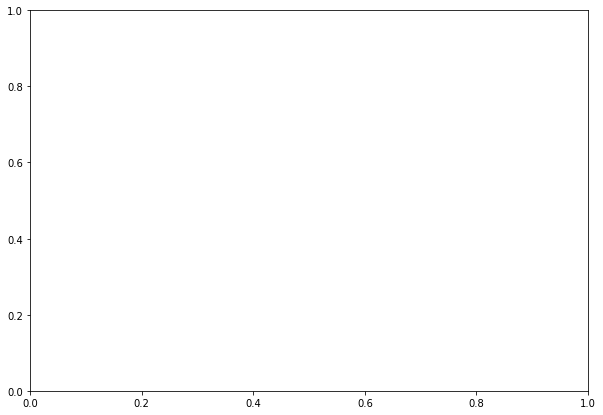

In [66]:
from lib.YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(smoothed[110:120,:].transpose(),fig,ax,title='smoothed %s for %s'%(measurement,stat));
plt.savefig('percipitation.png')
#title('A sample of graphs');

NameError: name 'orig' is not defined

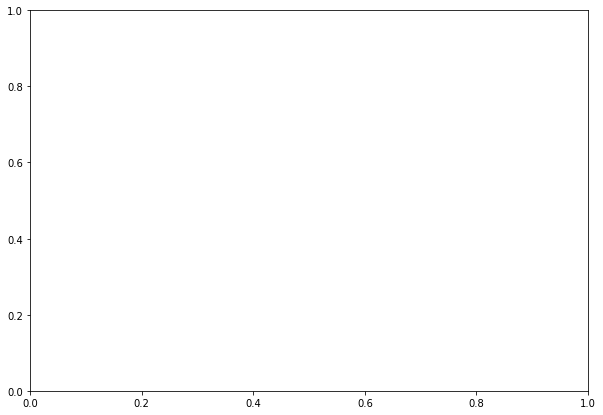

In [67]:
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
i=85
factor=5
pair=np.stack([orig[i,:],smoothed[i,:]*factor])
pair.shape

YP.plot(pair.transpose(),fig,ax,title='smoothed %s for %s'%(measurement,stat));

In [68]:
from scipy import signal
from astropy.convolution import convolve
window = signal.gaussian(81, std=20)

window/=sum(window)

In [69]:
P=T[3,:]
P[10:30]=np.nan
f=filtered = convolve(P, window)
print(len(f))
plot(f)
plot(P)

NameError: name 'T' is not defined

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [70]:
from MultiPlot import *                
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

ImportError: No module named 'MultiPlot'

In [71]:
plot_pair(['TMIN','TMAX'],plot_valid)

NameError: name 'plot_pair' is not defined

In [72]:
plot_pair(['TOBS','PRCP'],plot_valid)

NameError: name 'plot_pair' is not defined

In [73]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

NameError: name 'plot_pair' is not defined

### Plots of mean and std of observations

In [74]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



In [75]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

NameError: name 'plot_pair' is not defined

In [76]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

NameError: name 'plot_pair' is not defined

In [77]:
plot_single('TOBS',plot_mean_std,'r_figures/TOBS.png')

NameError: name 'plot_single' is not defined

In [78]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

NameError: name 'plot_pair' is not defined

In [79]:
plot_single('SNOW',plot_mean_std,'r_figures/SNOW.png')

NameError: name 'plot_single' is not defined

In [80]:
plot_single('SNWD',plot_mean_std,'r_figures/SNWD.png')

NameError: name 'plot_single' is not defined

### plotting top 3 eigenvectors

In [81]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

In [82]:
plot_pair(['TMIN','TMAX'],plot_eigen)

NameError: name 'plot_pair' is not defined

In [83]:
plot_pair(['TOBS','PRCP'],plot_eigen)

NameError: name 'plot_pair' is not defined

In [84]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

NameError: name 'plot_pair' is not defined

### Script for plotting percentage of variance explained

In [85]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

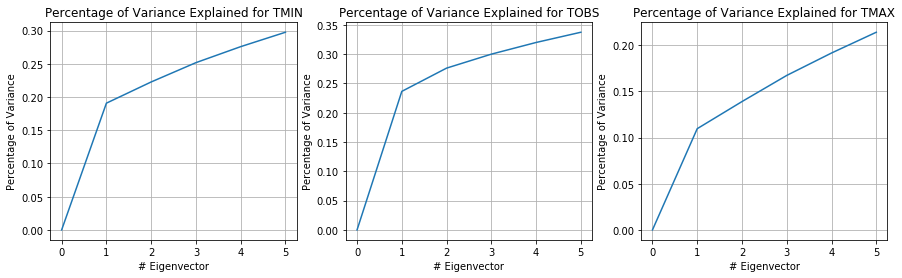

In [86]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

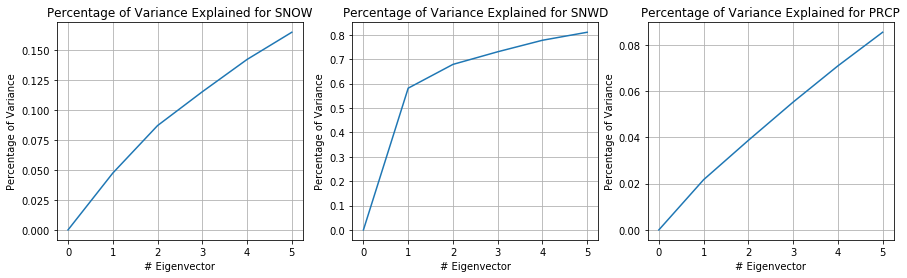

In [87]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png')

In [88]:
#sc.stop()